In [2]:
%pylab inline
import seaborn as sns
sns.set_style('ticks')
sns.set_context('poster', font_scale=2.0)
%config InlineBackend.figure_format = 'retina'

plt.rcParams['figure.figsize'] = (12.8, 9.6)
plt.rcParams['figure.facecolor'] = 'white'


Populating the interactive namespace from numpy and matplotlib


In [3]:
import pickle

In [73]:
from tqdm import tqdm_notebook as tqdm

In [18]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

In [22]:
import scipy

import scipy.constants as sc
hbarc = ( sc.hbar * sc.speed_of_light
         / sc.mega / sc.electron_volt / sc.femto )
ainv = 2.194e3 # lattice cutoff in GeV
lat_unit = hbarc/ainv # lattice spacing in fm

mxi = 0.665 # mass of Xi in lattice unit
mpi = 510/ainv # mass of pion in lattice unit

In [21]:
print(np.__version__)
print(scipy.__version__)
print(sns.__version__)
print(matplotlib.__version__)

1.14.2
1.0.0
0.8.1
2.2.2


# import data

In [113]:
ls ../data/potential

pot_1s0_xixi_L64.pkl                 pot_jk_1s0_xixi_L64_exp.pkl
pot_H0term_jk_1s0_xixi_L64_exp.pkl   pot_jk_1s0_xixi_L64_wall.pkl
pot_H0term_jk_1s0_xixi_L64_wall.pkl


In [26]:
pot_jk_bin = {}
pot_H0_jk_bin = {}
for src in ['wall', 'exp']:
    with open(f'../data/potential/pot_jk_1s0_xixi_L64_{src}.pkl', 'rb') as fin:
        _, rs, pot_jk_bin[src] = pickle.load(fin)
    with open(f'../data/potential/pot_H0term_jk_1s0_xixi_L64_{src}.pkl', 'rb') as fin:
        _, rs, pot_H0_jk_bin[src] = pickle.load(fin)

In [29]:
pot_jk_bin['wall'][13].shape

(20, 6545)

In [34]:
its = list(pot_jk_bin['wall'].keys()) # list of t
bin_num = pot_jk_bin['wall'][its[0]].shape[0] # number of jack-knife samples

# check data

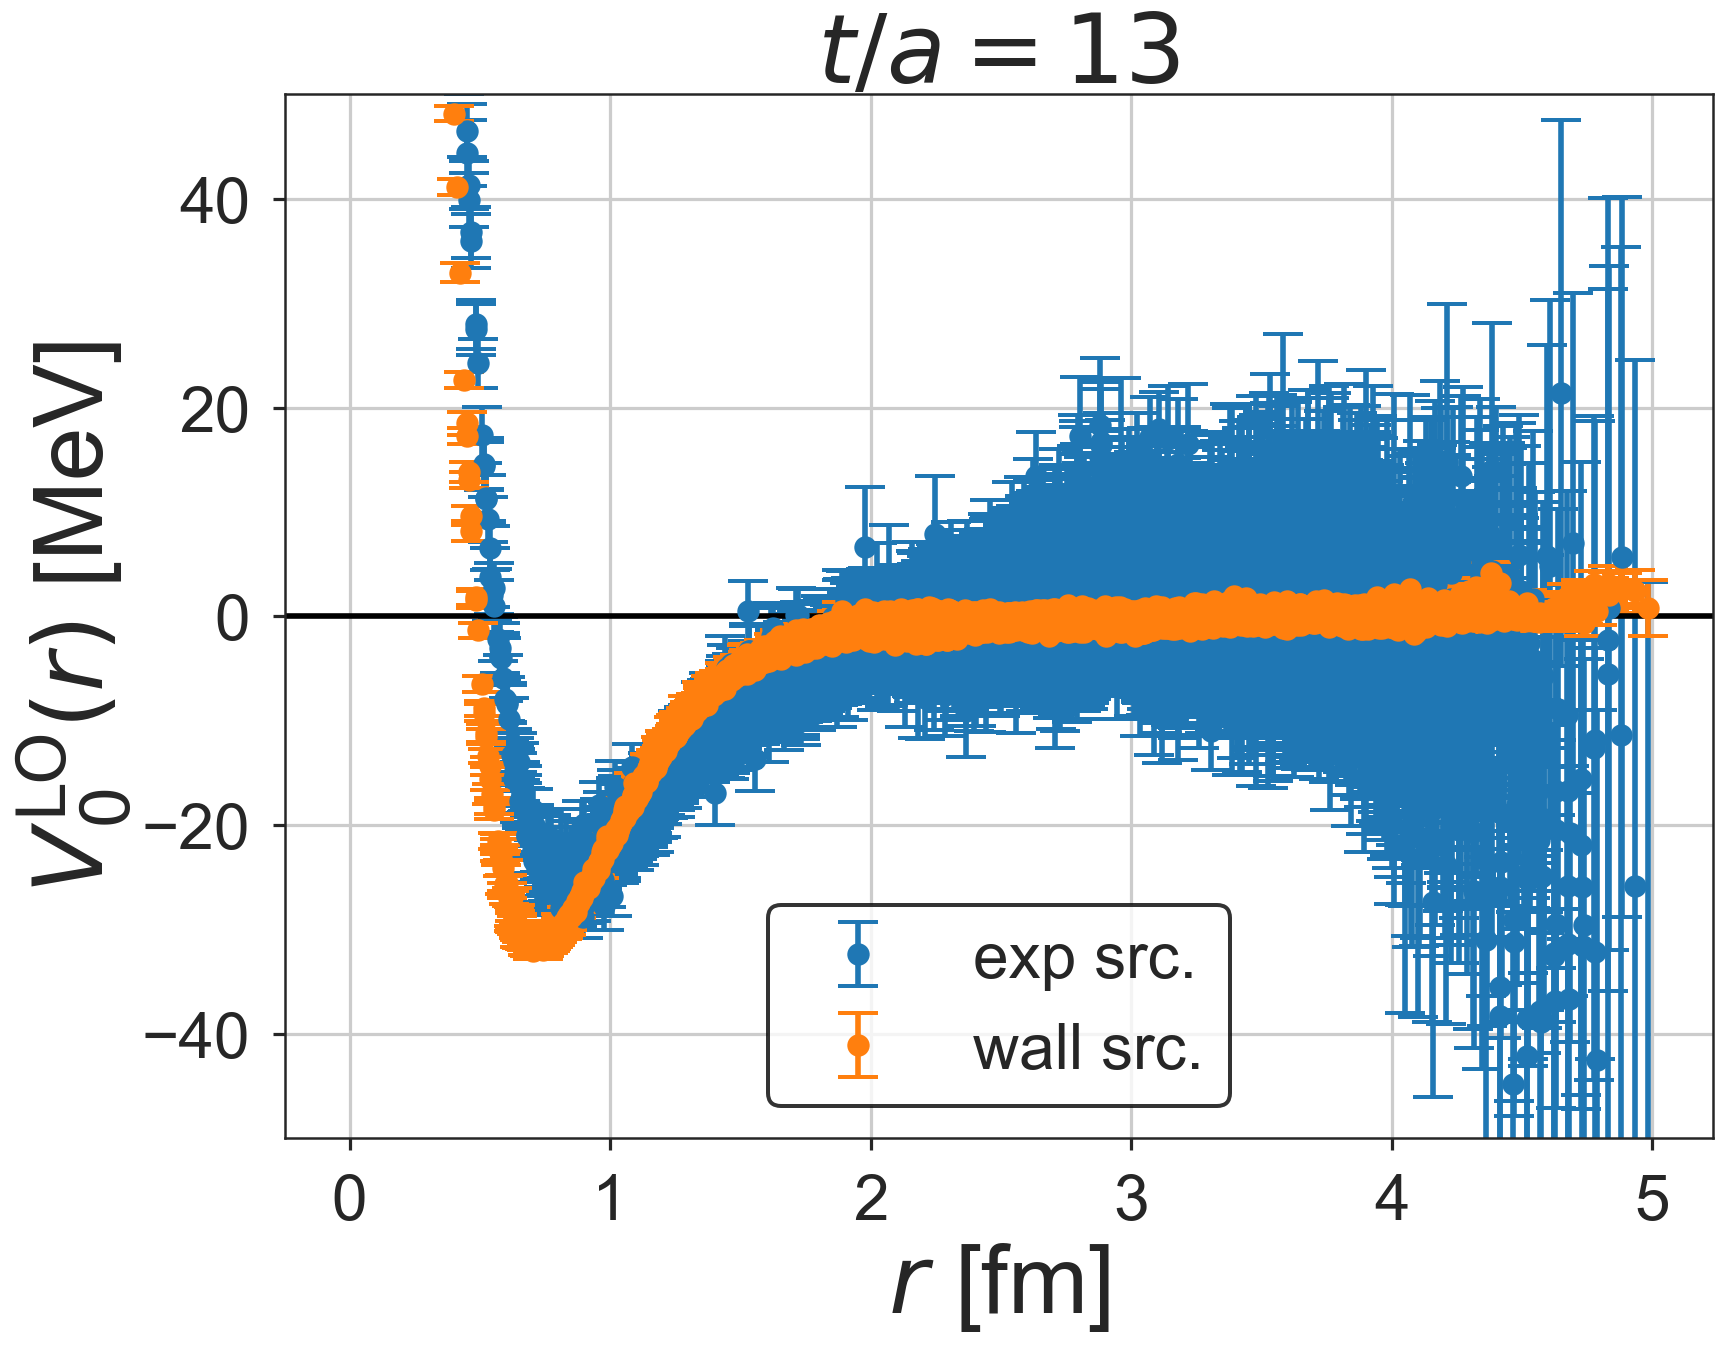

In [39]:
it = 13
fig, ax = plt.subplots()
for src, src_lbl in zip(['exp', 'wall'], ['smeared', 'wall']):
    ys_jk = pot_jk_bin[src][it]
    ax.errorbar(rs*lat_unit, ys_jk.mean(axis=0)*ainv, 
            ys_jk.std(axis=0) * np.sqrt(bin_num - 1)*ainv,
            fmt='o', capsize=10, capthick=2.0, label=f'{src} src.')
ax.set_ylim(-50, 50)
ax.set_title(rf'$t/a = {it}$', size=48)
ax.axhline(0, color='black')
ax.grid()
ax.set_xlabel(r'$r$ [fm]', size=48)
ax.set_ylabel(r'$V_0^\mathrm{LO}(r)$ [MeV]', size=48)
leg = ax.legend(frameon=True)
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_linewidth(2.0)

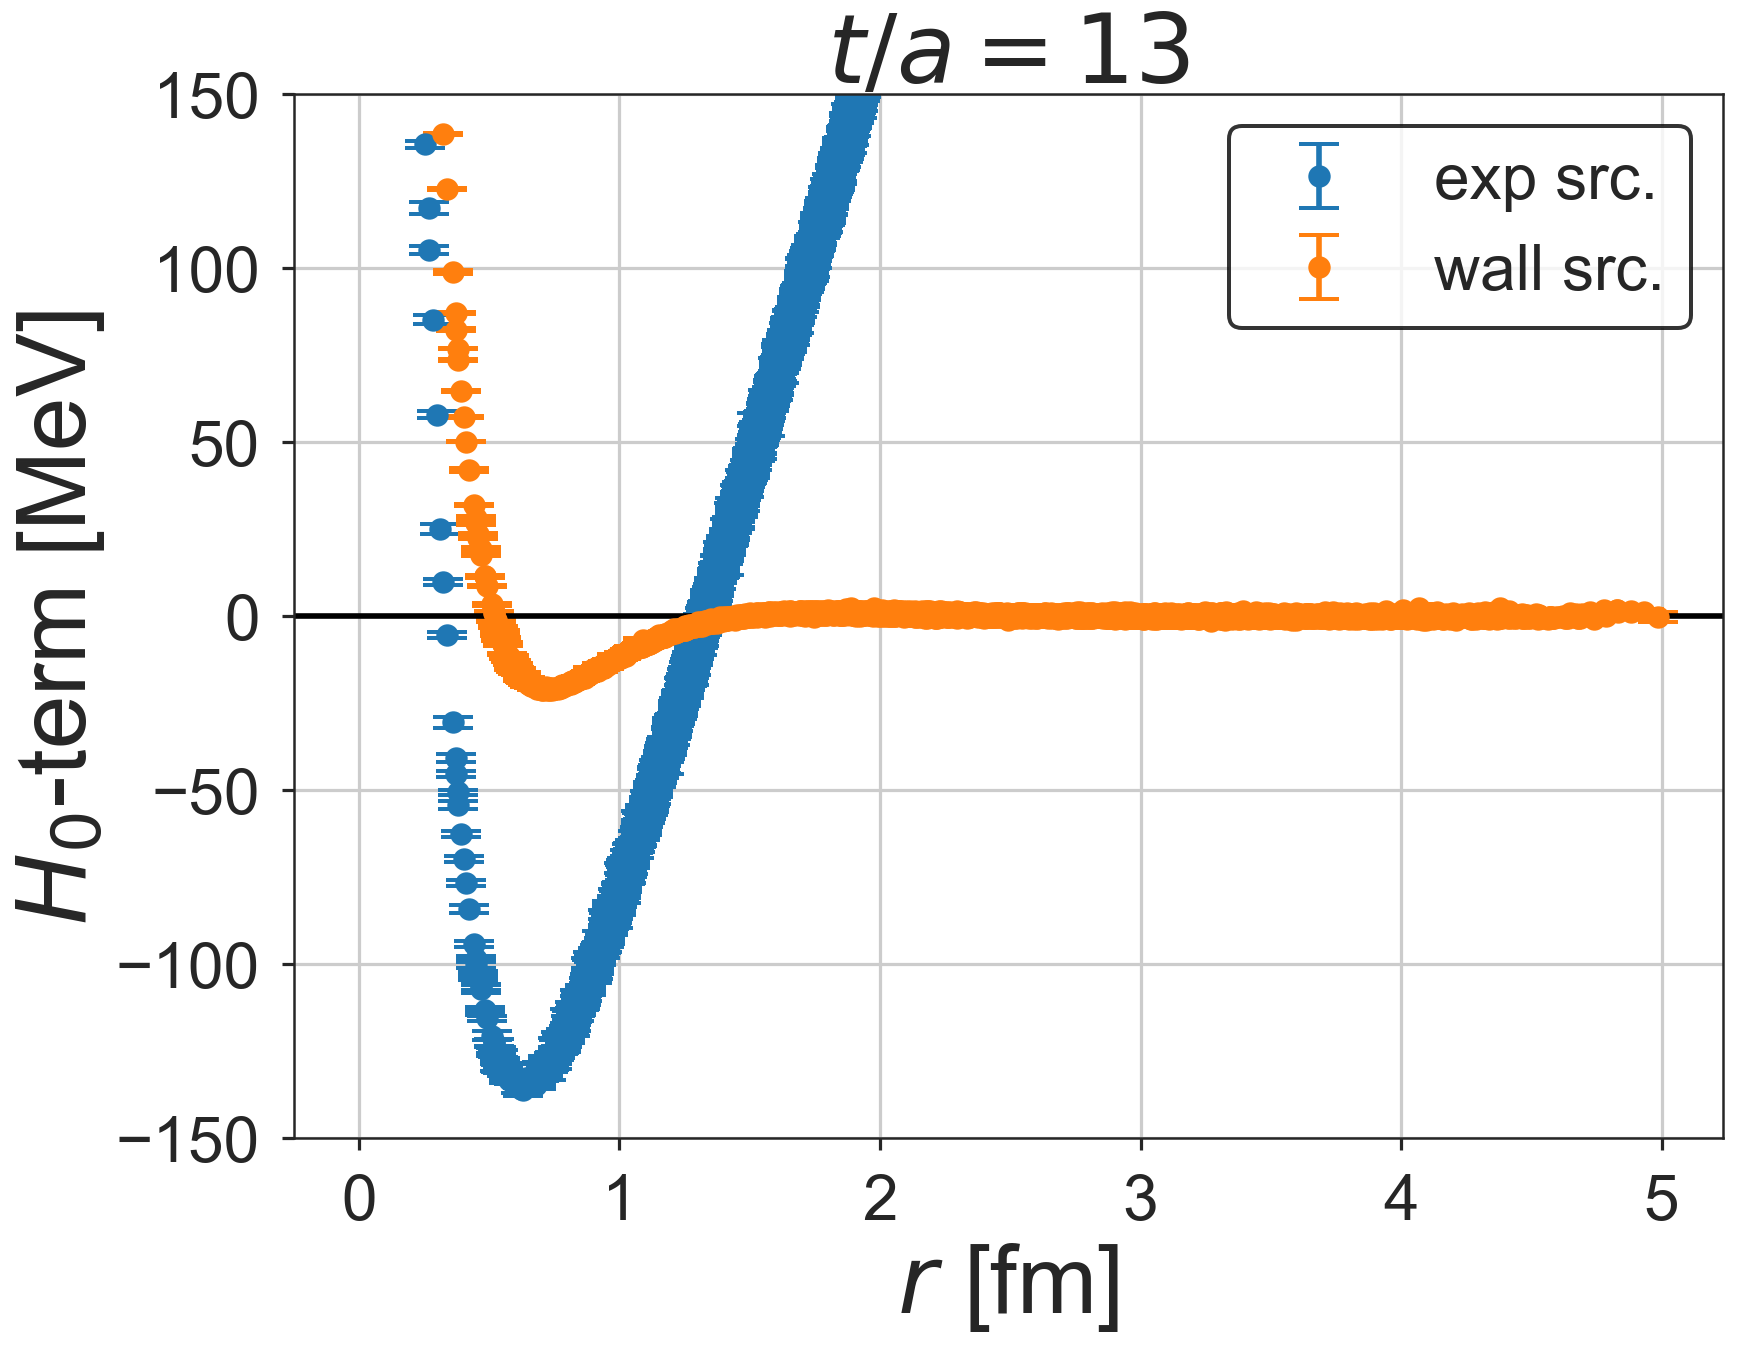

In [41]:
it = 13
fig, ax = plt.subplots()
for src, src_lbl in zip(['exp', 'wall'], ['smeared', 'wall']):
    ys_jk = pot_H0_jk_bin[src][it]
    ax.errorbar(rs*lat_unit, ys_jk.mean(axis=0)*ainv, 
            ys_jk.std(axis=0) * np.sqrt(bin_num - 1)*ainv,
            fmt='o', capsize=10, capthick=2.0, label=f'{src} src.')
ax.set_ylim(-150, 150)
ax.set_title(rf'$t/a = {it}$', size=48)
ax.axhline(0, color='black')
ax.grid()
ax.set_xlabel(r'$r$ [fm]', size=48)
ax.set_ylabel(r'$H_0$-term [MeV]', size=48)
leg = ax.legend(frameon=True)
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_linewidth(2.0)

# decompress data

Only A1 unique points are stored in pickle file.

In [102]:
L = 64
rs_full = np.array([np.sqrt(ix**2 + iy**2 + iz**2)
                    for ix in range(-L//2,L//2)
                    for iy in range(-L//2,L//2)
                    for iz in range(-L//2,L//2)]).reshape(L,L,L)
rs_full = np.roll(rs_full, (L//2,L//2,L//2), axis=(0,1,2)).flatten()


In [104]:
a1_uniq = np.array([ix + L * (iy + L * iz)
                   for ix in range(0, L//2+1)
                   for iy in range(0, ix+1)
                   for iz in range(0, iy+1)])

In [87]:
a1_uniq_ind = {}
ind = 0
for ix in range(0, L//2+1):
    for iy in range(0, ix+1):
        for iz in range(0, iy+1):
            a1_uniq_ind[(ix, iy, iz)] = ind
            ind += 1
xyz_ind = {}
for ix in range(L):
    for iy in range(L):
        for iz in range(L):
            _ind = np.sort([min(ix,L-ix), min(iy,L-iy), min(iz,L-iz)])[::-1]
            xyz_ind[(ix,iy,iz)] = a1_uniq_ind[(_ind[0], _ind[1], _ind[2])]

In [92]:
pot_jk_bin_full = {}
for src in ['wall', 'exp']:
    pot_jk_bin_full[src] = {}
    for it in tqdm(its):
        pot_full = np.zeros((bin_num, L, L, L))
        for ix in range(L):
            for iy in range(L):
                for iz in range(L):
                    pot_full[:,ix,iy,iz] = pot_jk_bin[src][it][:,xyz_ind[(ix,iy,iz)]]
        pot_jk_bin_full[src][it] = pot_full.reshape(bin_num, L**3)

HBox(children=(IntProgress(value=0, max=7), HTML(value='')))

HBox(children=(IntProgress(value=0, max=7), HTML(value='')))

In [93]:
pot_H0_jk_bin_full = {}
for src in ['wall', 'exp']:
    pot_H0_jk_bin_full[src] = {}
    for it in tqdm(its):
        pot_H0_full = np.zeros((bin_num, L, L, L))
        for ix in range(L):
            for iy in range(L):
                for iz in range(L):
                    pot_H0_full[:,ix,iy,iz] = pot_H0_jk_bin[src][it][:,xyz_ind[(ix,iy,iz)]]
        pot_H0_jk_bin_full[src][it] = pot_H0_full.reshape(bin_num, L**3)

HBox(children=(IntProgress(value=0, max=7), HTML(value='')))

HBox(children=(IntProgress(value=0, max=7), HTML(value='')))

# diff of potentials

In [94]:
dV_LO_jk = {}
dLapR_jk = {}
for it in its:
    dV_LO_jk[it] = pot_jk_bin_full['wall'][it] - pot_jk_bin_full['exp'][it]
    dLapR_jk[it] = mxi * (pot_H0_jk_bin_full['wall'][it] - pot_H0_jk_bin_full['exp'][it])

[-0.52491935  0.07894606  2.29100185 -0.10993918  0.22161887  7.05704236]


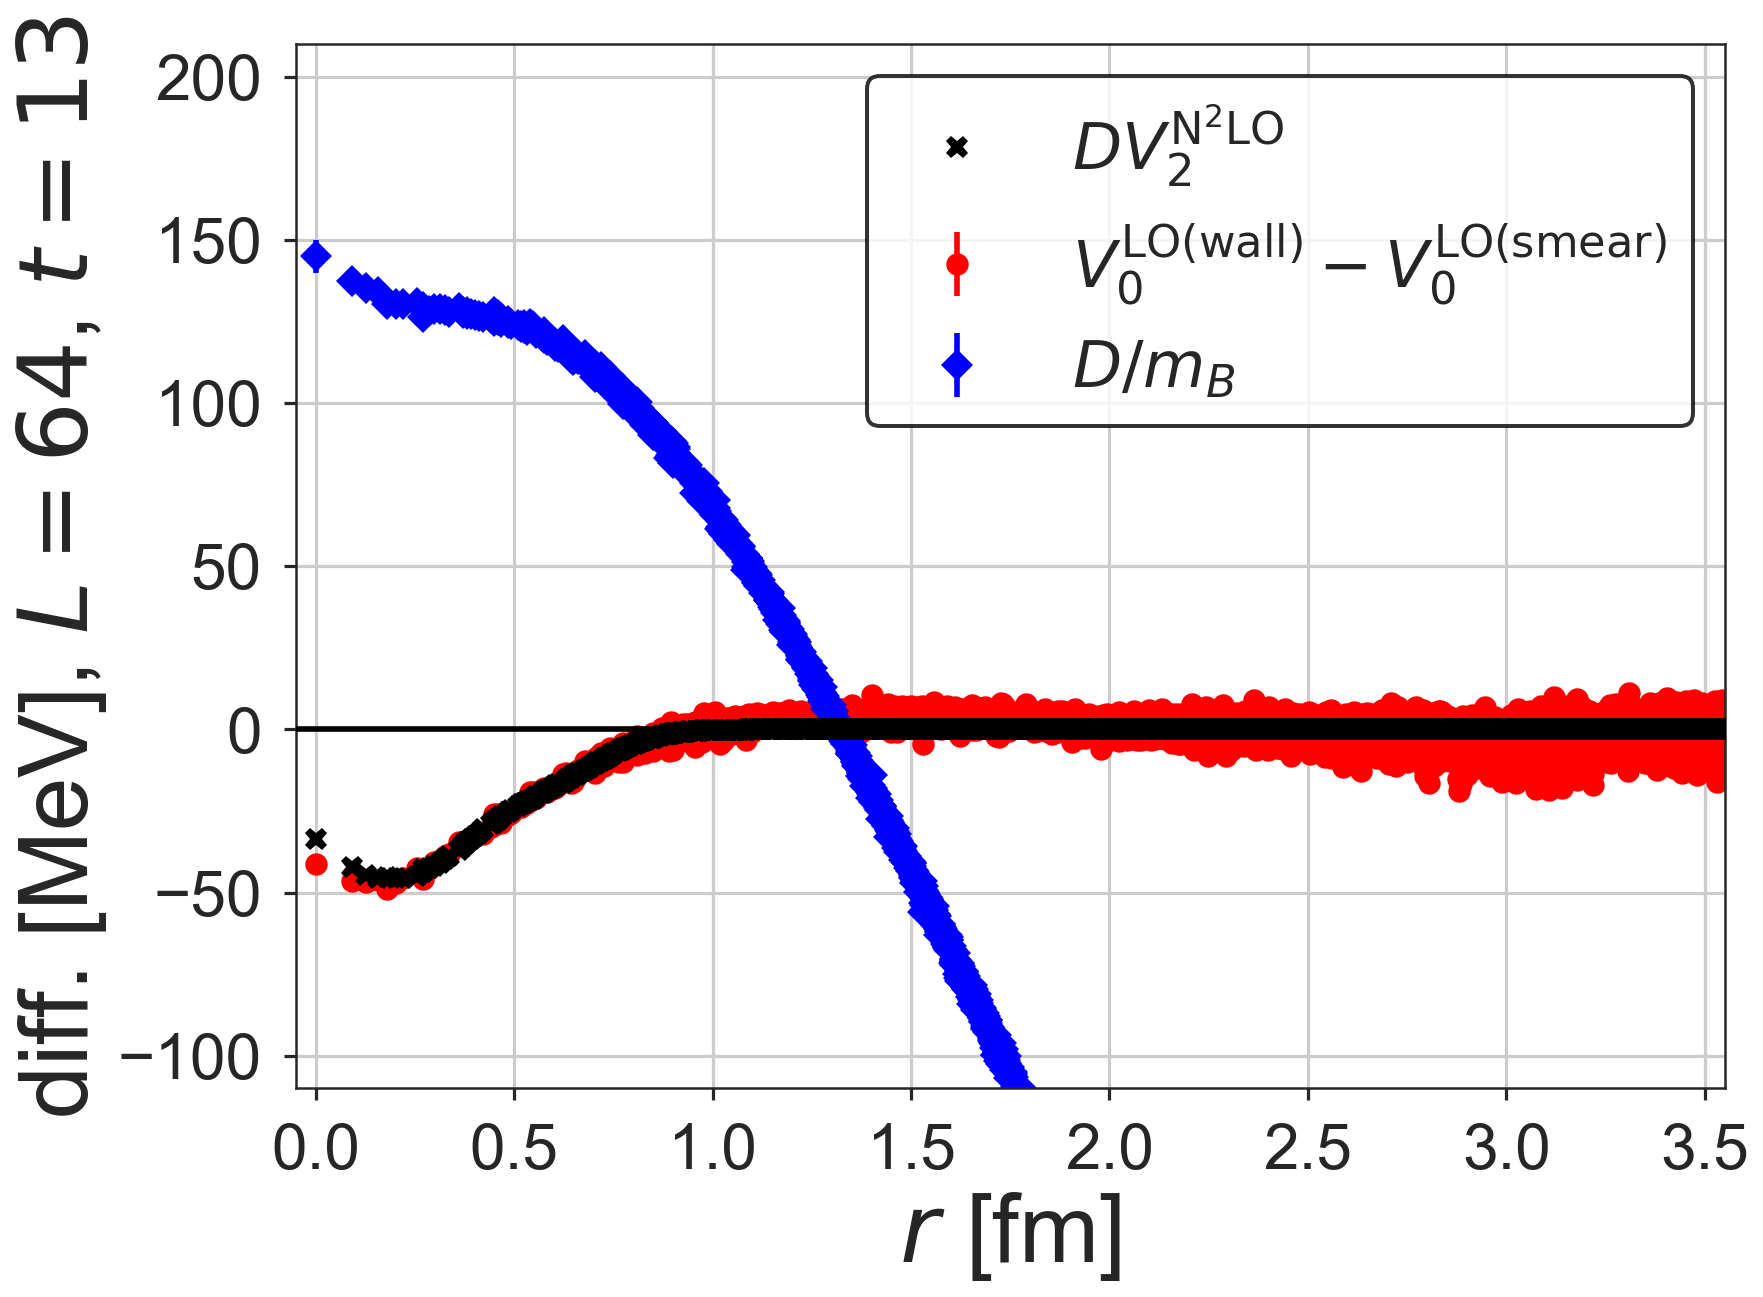

In [106]:
it = 13
fig, ax = plt.subplots()

ax.errorbar(rs * lat_unit, dV_LO_jk[it].mean(axis=0)[a1_uniq] * ainv,
            dV_LO_jk[it].std(axis=0)[a1_uniq] * np.sqrt(bin_num - 1),
           fmt='o', color='red', label=r'$V_0^\mathrm{LO(wall)} - V_0^\mathrm{LO(smear)}$')
ax.errorbar(rs * lat_unit, dLapR_jk[it].mean(axis=0)[a1_uniq]/mxi * ainv,
            dLapR_jk[it].std(axis=0)[a1_uniq] * np.sqrt(bin_num - 1)/mxi * ainv,
            fmt='D', color='blue',
            label=r'$D/m_B$')
# fitting
p0 = np.array([-4.9e-1, 1.1e-1, 2.6e0, -1.5e-1, 2.0e-1, 6.8e0])
pot_2gauss = lambda p, x: p[0]*np.exp(-p[1]*(x-p[2])**2) + p[3]*np.exp(-p[4]*(x-p[5])**2)
errf = lambda p, y, x, dfac, err: (dfac * pot_2gauss(p, x) - y)/err
fitr = (0, 30) 
mask = (rs_full >= fitr[0]) & (rs_full <= fitr[1])
pfit = scipy.optimize.leastsq(errf, p0, args=(dV_LO_jk[it].mean(axis=0)[mask],
                                             rs_full[mask], dLapR_jk[it].mean(axis=0)[mask],
                                             dV_LO_jk[it].std(axis=0)[mask]*np.sqrt(bin_num-1)),
                             full_output=True)
print(pfit[0])
ax.plot(rs*lat_unit, dLapR_jk[it].mean(axis=0)[a1_uniq] * pot_2gauss(pfit[0], rs) * ainv, 'X', color='black',
       label=r'$D V_2^\mathrm{N^2LO}$', zorder=5)

ax.set_xlim(-0.05,3.55)
ax.set_xticks([0,0.5,1.0,1.5, 2.0, 2.5, 3.0, 3.5])
ax.set_ylim(-110, 210)
ax.set_xlabel(r'$r$ [fm]', fontsize=48)
ax.set_ylabel(r'diff. [MeV], $L=64$, $t = {}$'.format(it), fontsize=48)
ax.grid()
ax.axhline(0, color='black', zorder=3)
leg = ax.legend(frameon=True)
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_linewidth(2.0)

# N2LO potential

In [107]:
def calc_N2LO_pot_jk(ibin, err, it, fitr=(0, 30)):
    p0 = np.array([-4.9e-1, 1.1e-1, 2.6e0, -1.5e-1, 2.0e-1, 6.8e0])
    pot_2gauss = lambda p, x: p[0]*np.exp(-p[1]*(x-p[2])**2) + p[3]*np.exp(-p[4]*(x-p[5])**2)
    errf = lambda p, y, x, dfac, err: (dfac * pot_2gauss(p, x) - y)/err
    mask = (rs_full >= fitr[0]) & (rs_full <= fitr[1])
    
    pfit = scipy.optimize.leastsq(errf, p0,
                                 args=(dV_LO_jk[it][ibin,mask], rs_full[mask],
                                       dLapR_jk[it][ibin,mask], err[mask]),
                                  full_output=True)
    V2 = pot_2gauss(pfit[0], rs_full)
    V0 = pot_jk_bin_full['wall'][it][ibin,:] - V2 *  mxi * pot_H0_jk_bin_full['wall'][it][ibin,:]
    return V0, V2

In [111]:
V0_N2LO_jk = {}
V2_N2LO_jk = {}
for it in [13, 14, 15, 16]:
    diff_err = dV_LO_jk[it].std(axis=0) * np.sqrt(bin_num - 1)
    v0_list = []
    v2_list = []
    for ibin in tqdm(range(bin_num)):
        v0, v2 = calc_N2LO_pot_jk(ibin, diff_err, it=it)
        v0_list.append(v0)
        v2_list.append(v2)
        
    V0_N2LO_jk[it] = np.array(v0_list)
    V2_N2LO_jk[it] = np.array(v2_list)
    

HBox(children=(IntProgress(value=0, max=20), HTML(value='')))

HBox(children=(IntProgress(value=0, max=20), HTML(value='')))

HBox(children=(IntProgress(value=0, max=20), HTML(value='')))

HBox(children=(IntProgress(value=0, max=20), HTML(value='')))

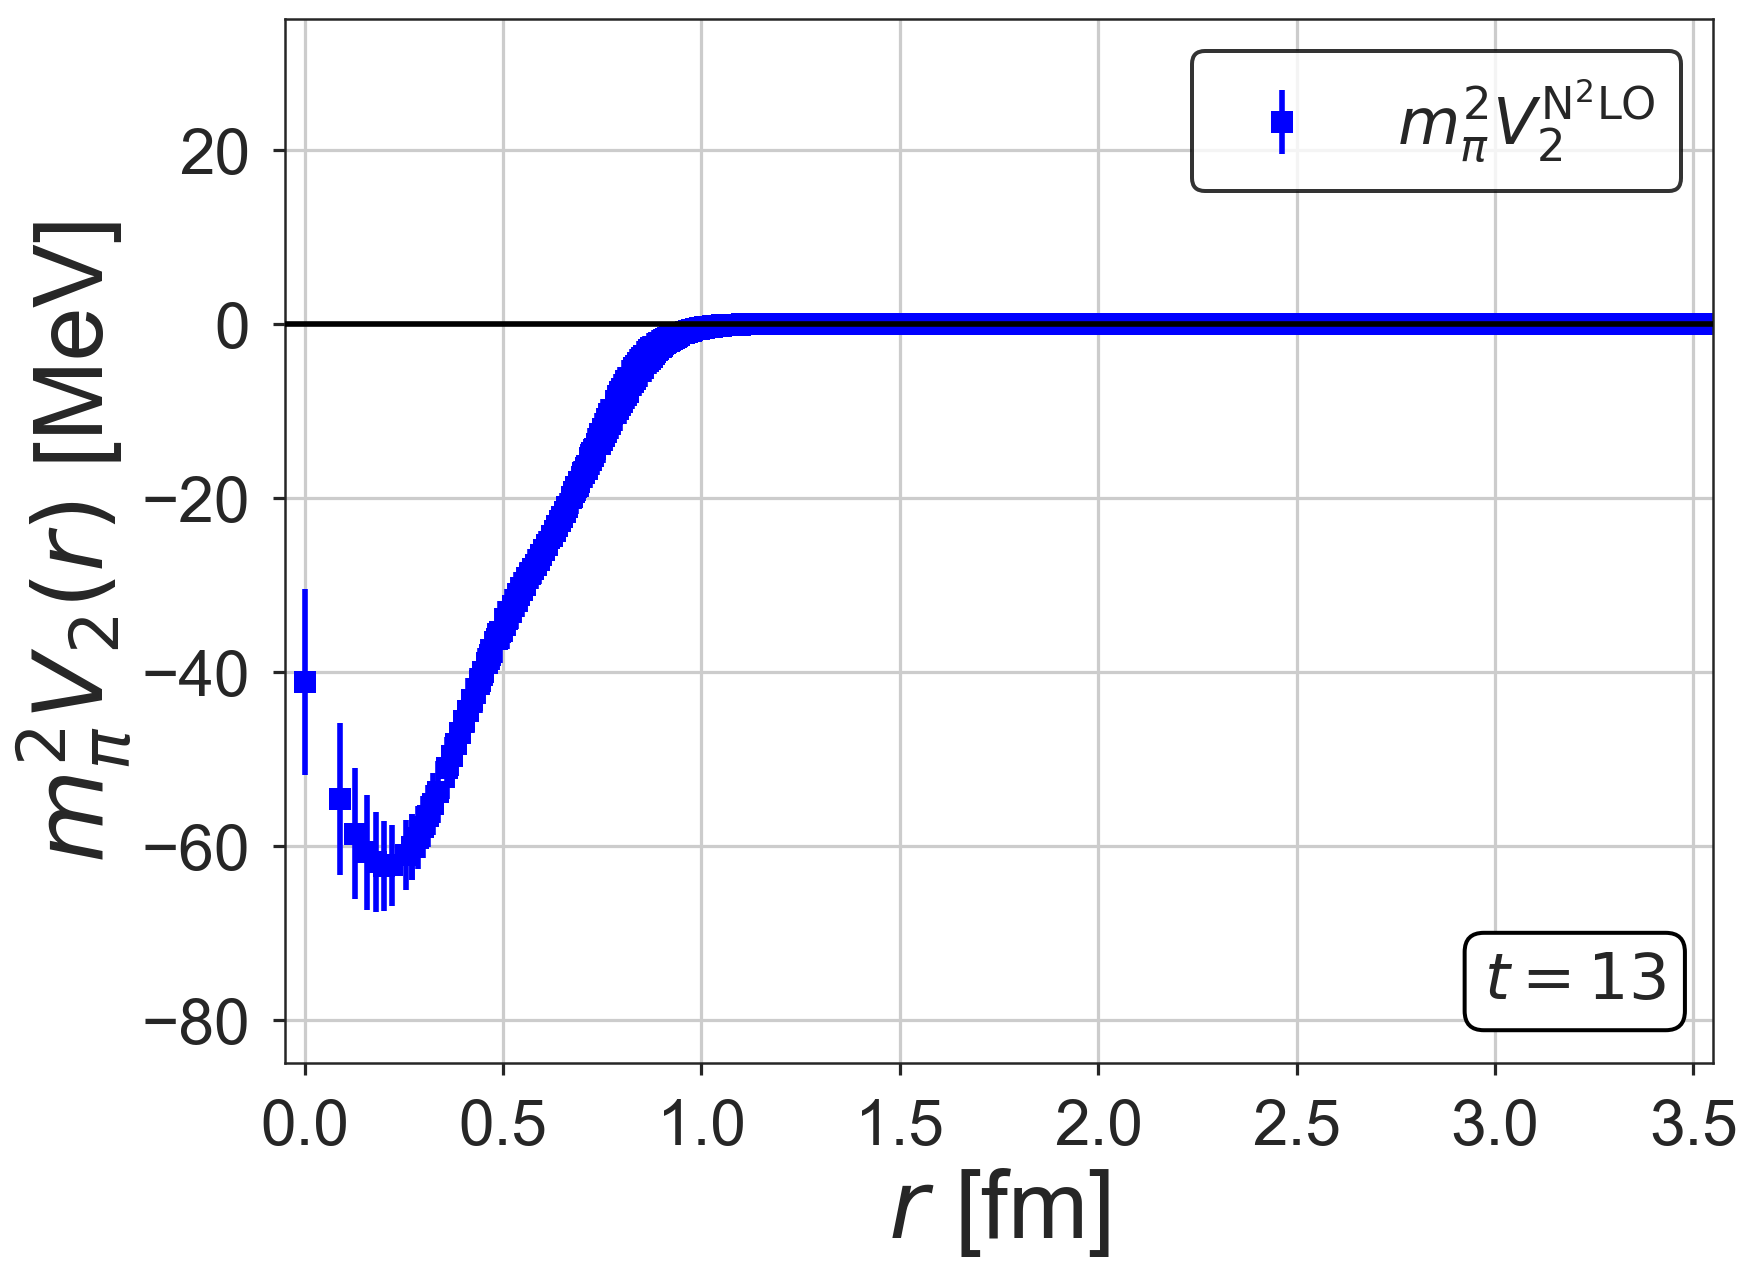

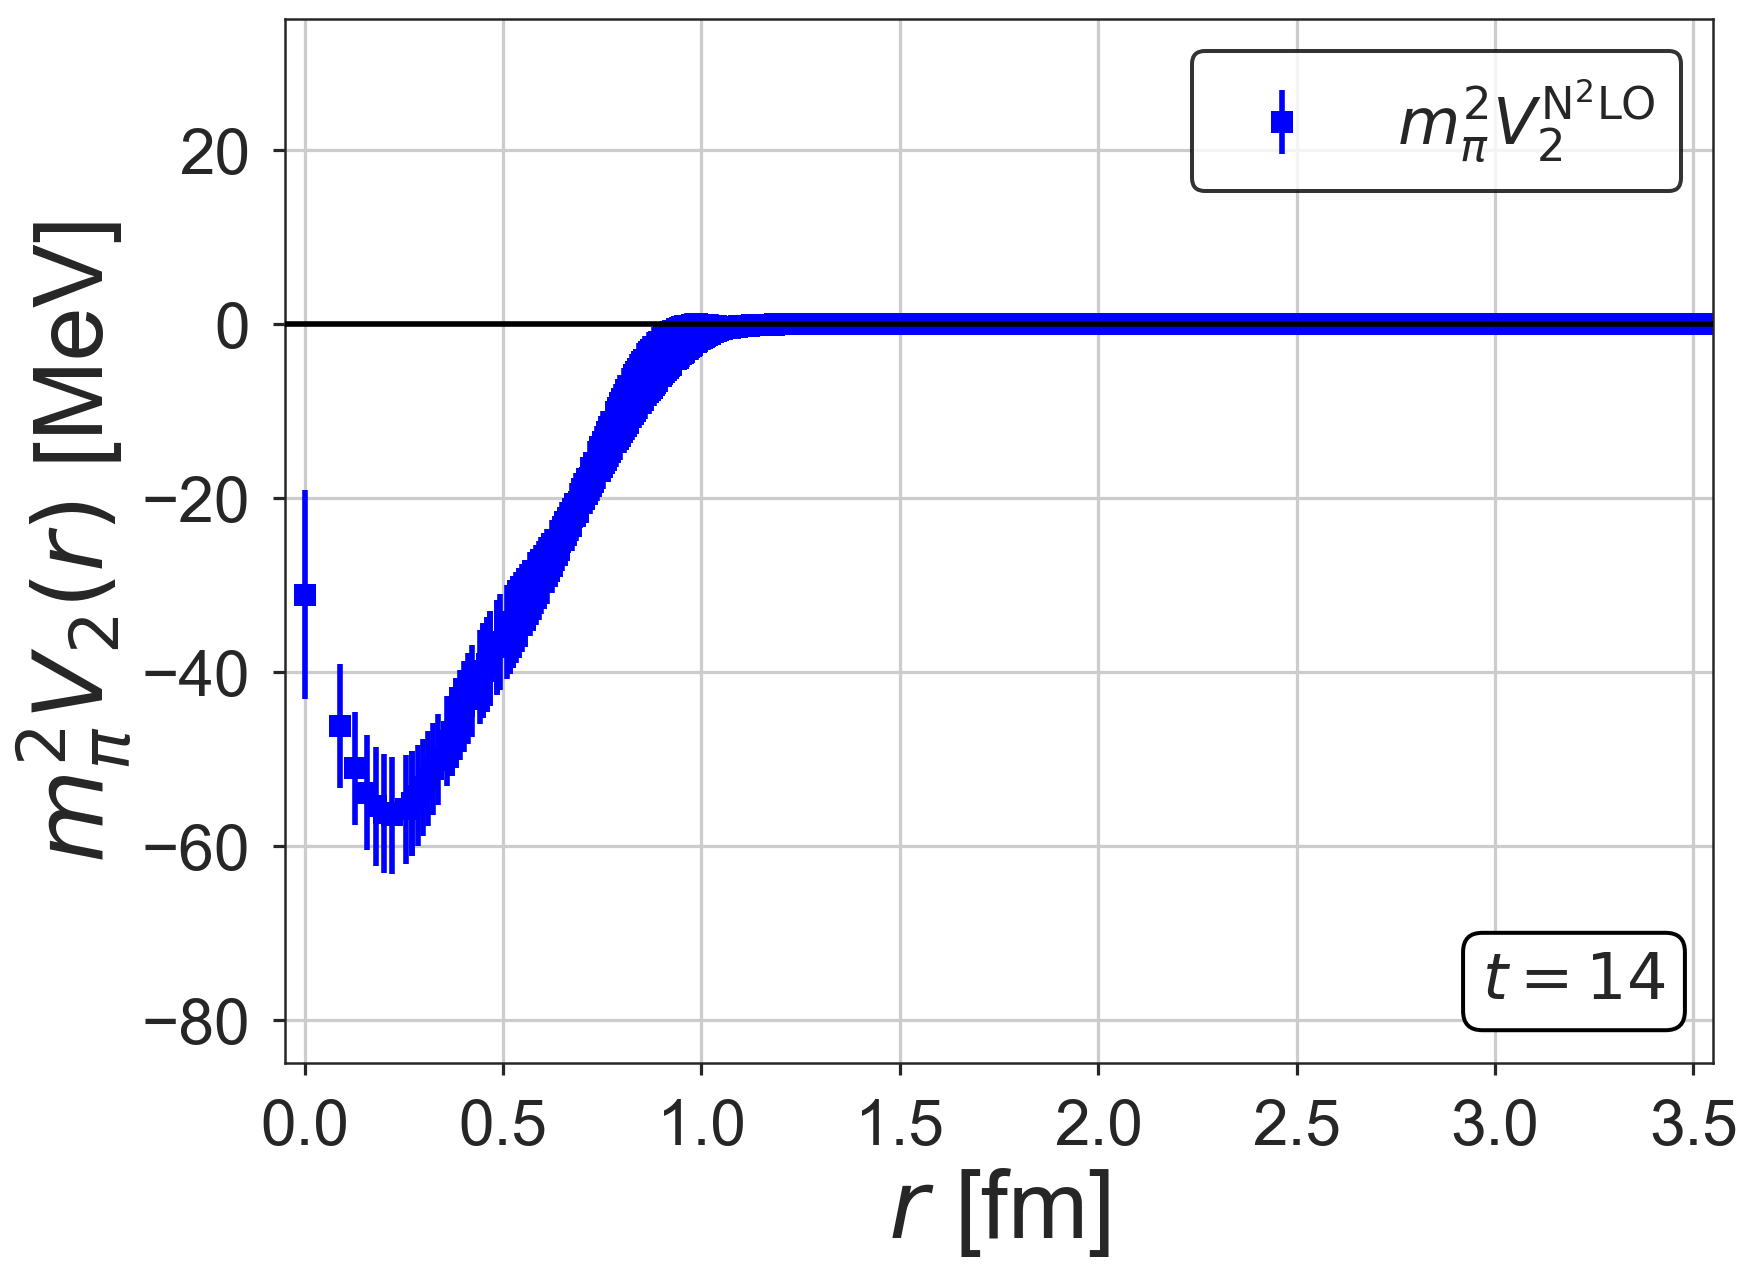

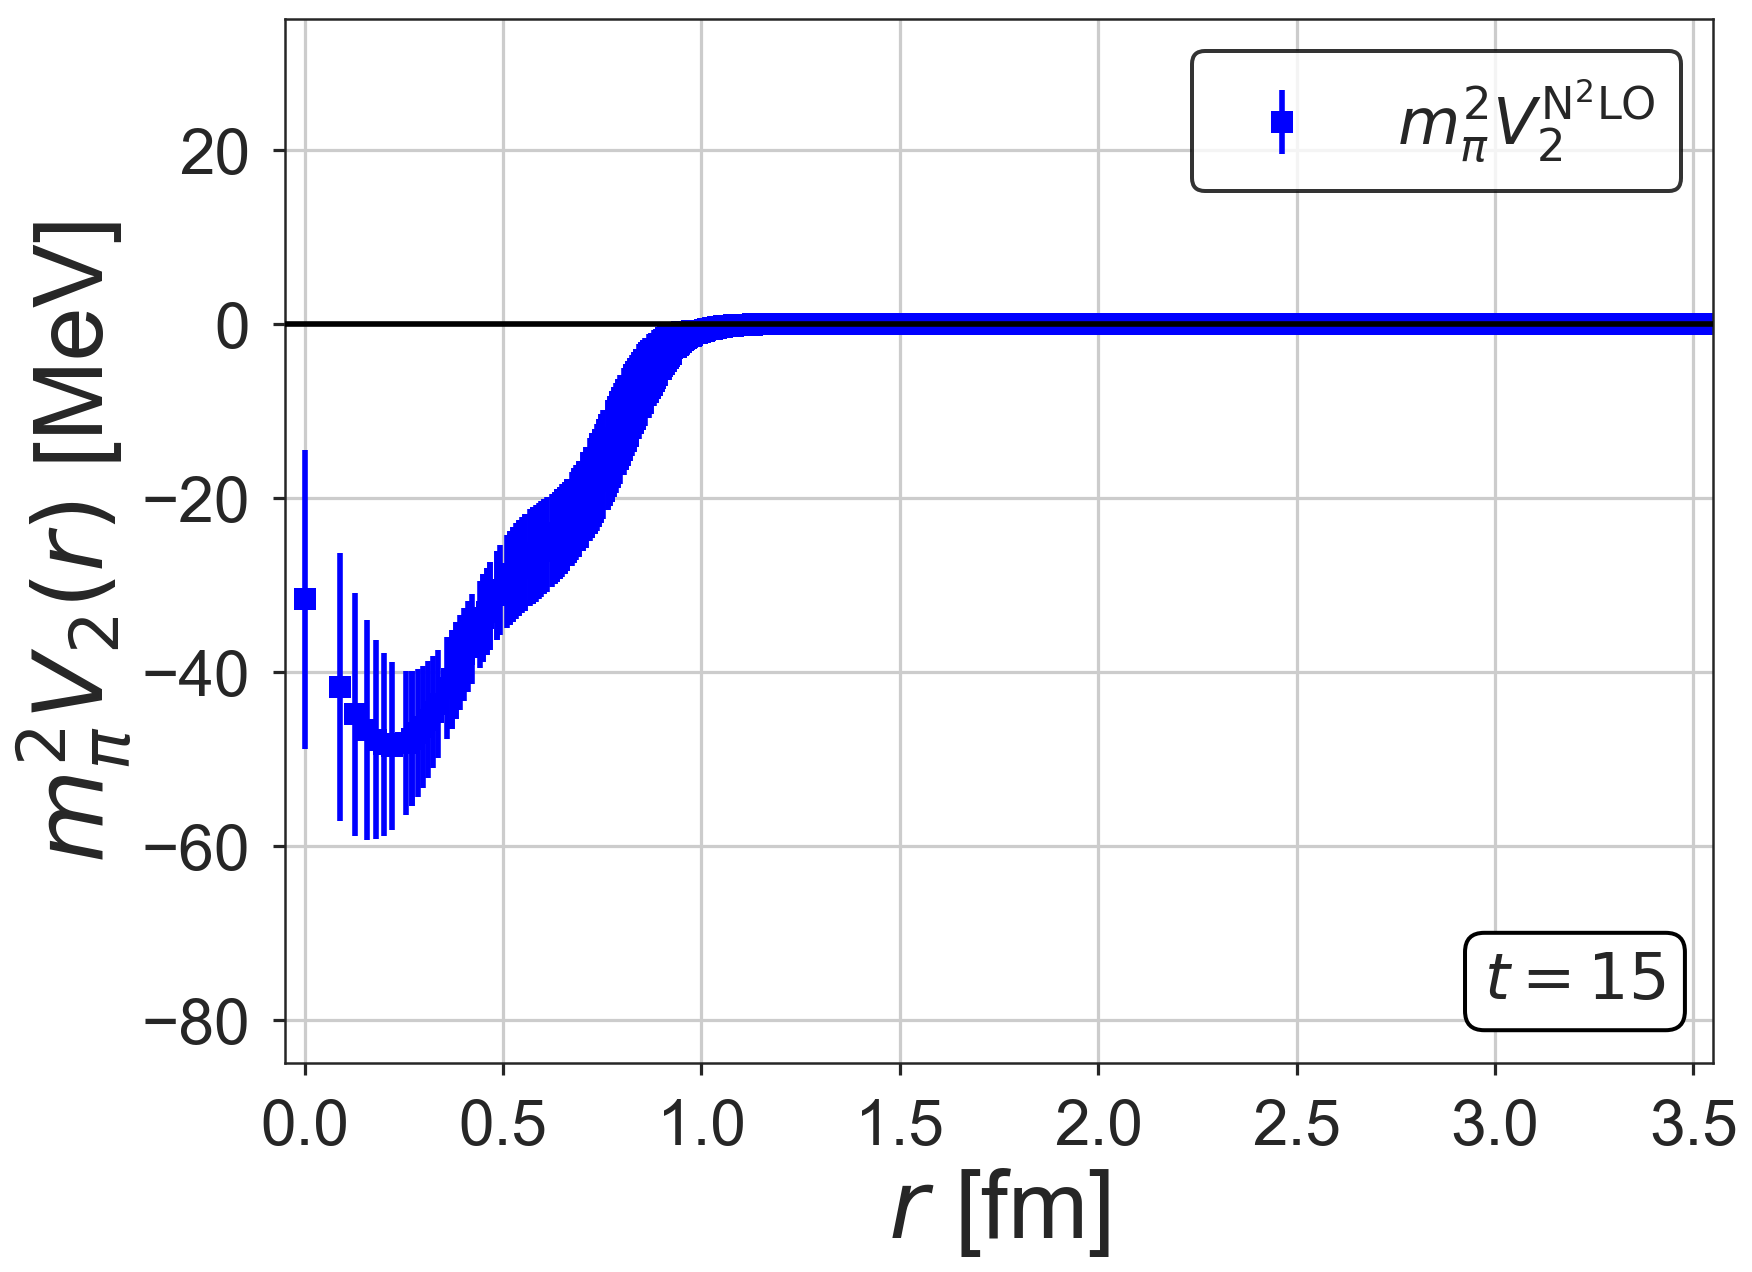

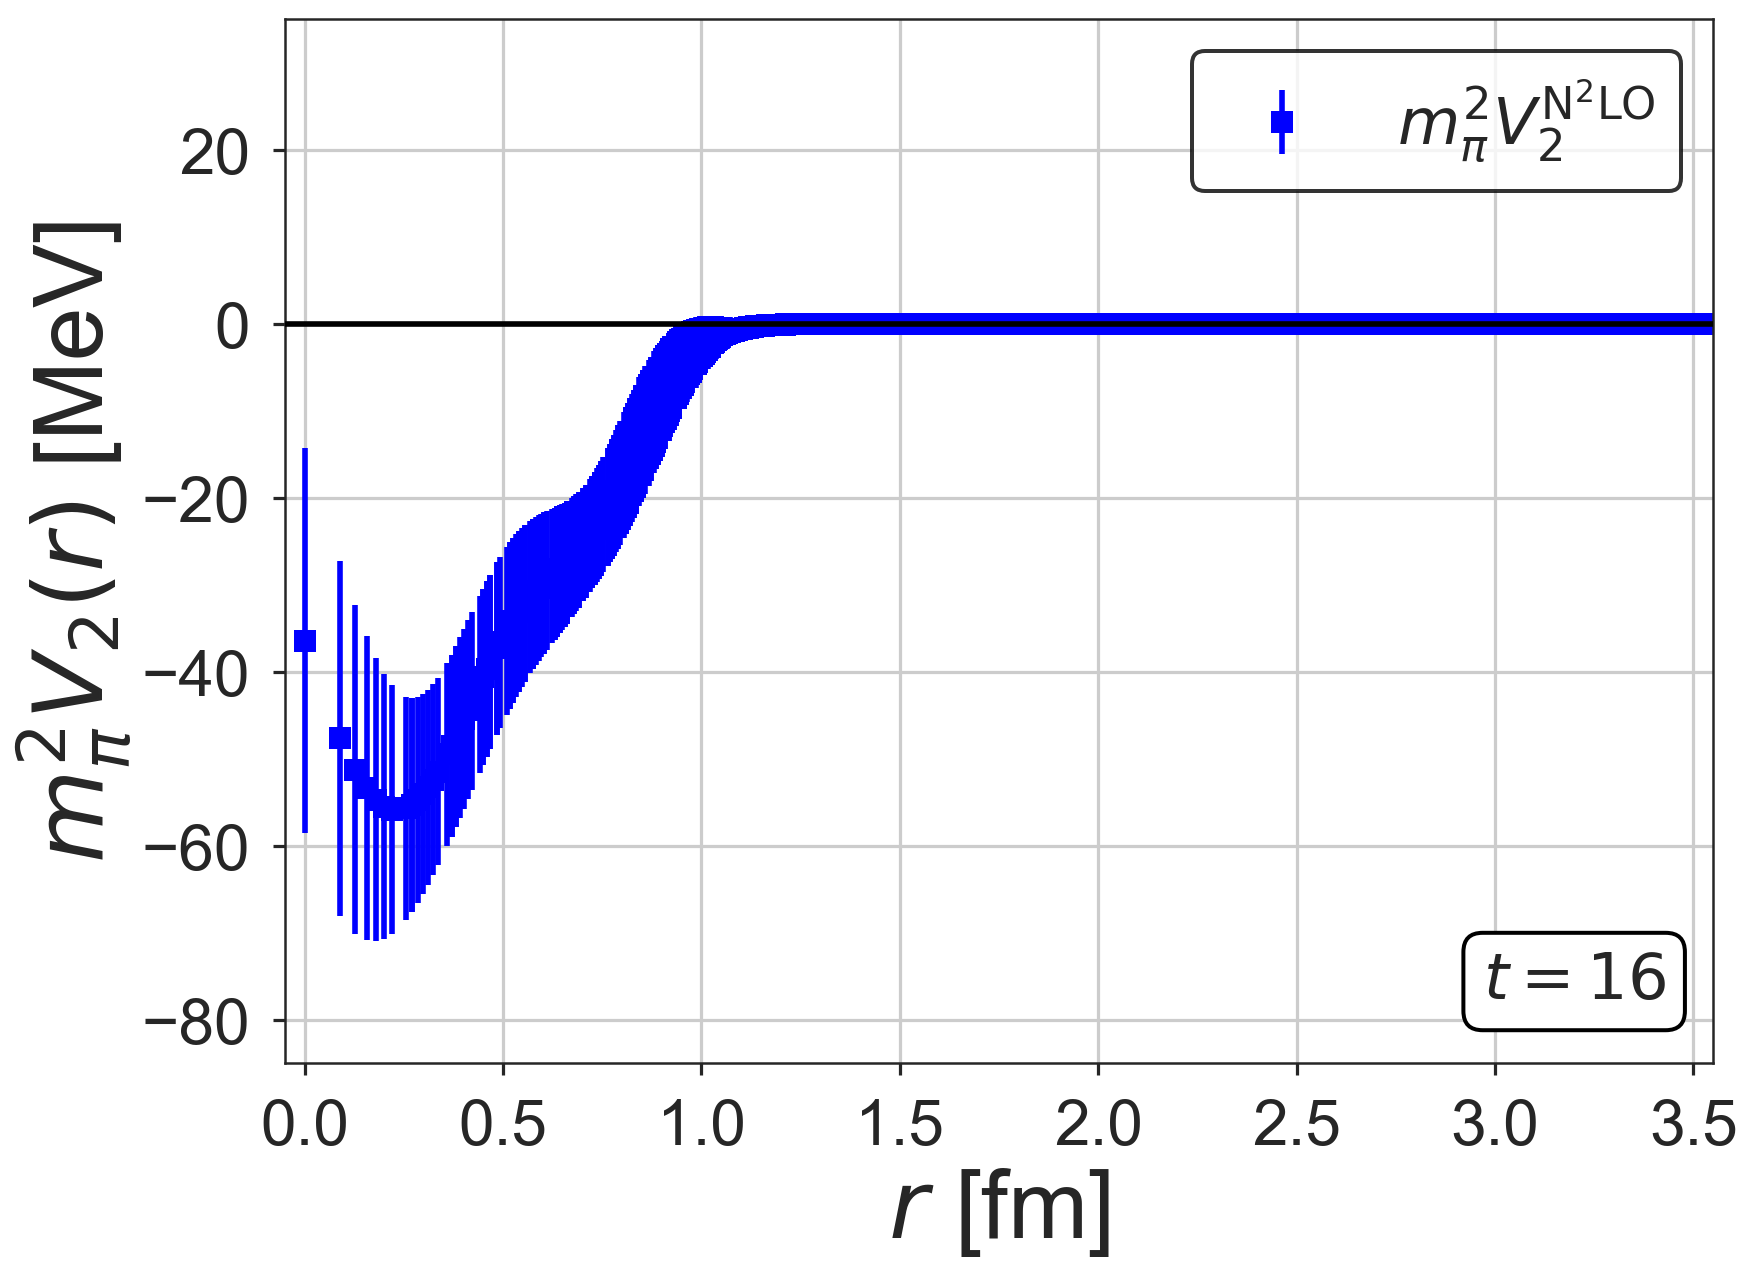

In [112]:
def plot_v2_n2lo(it):
    fig, ax = plt.subplots()

    ax.errorbar(lat_unit*rs, V2_N2LO_jk[it].mean(axis=0)[a1_uniq] *mpi**2*ainv, 
                V2_N2LO_jk[it].std(axis=0)[a1_uniq] * np.sqrt(bin_num - 1) * mpi**2*ainv,
               fmt='bs', label=r'$m_\pi^2V_2^\mathrm{N^2LO}$')

    xr = (-0.05, 3.55)
    yr = (-85, 35)
    ax.set_xlim(xr)
    ax.set_ylim(yr)
    ax.set_xticks([0,0.5,1.0,1.5, 2.0, 2.5, 3.0, 3.5])

    ax.grid()
    ax.set_xlabel(r'$r$ [fm]', fontsize=48)

    leg = ax.legend(loc='upper right', frameon=True, fontsize=32)
    leg.get_frame().set_edgecolor('black')
    leg.get_frame().set_linewidth(2.0)

    xr = (0, 3.5)
    props = dict(boxstyle='round', facecolor='white', linewidth=2, alpha=1.0)
    ax.text(xr[0]+0.98*(xr[1]-xr[0]), yr[0] + 0.05*(yr[1]-yr[0]), 
                   rf'$t = {it}$', fontsize=32, bbox=props,
                   horizontalalignment='right',
                   verticalalignment='bottom')


    ax.axhline(0, color='black',zorder=5)
    ax.set_xlabel(r'$r$ [fm]', fontsize=48)
    ax.set_ylabel(r'$m_\pi^2V_2(r)$ [MeV]', fontsize=48)
#    fig.savefig(f'LO_potential_plot/pot_v2_t{it}.png', bbox_inches='tight')
    
for it in [13, 14, 15, 16]:
    plot_v2_n2lo(it)
